In [1]:
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader.data import DataReader

import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

In [2]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/pengembangan-ML-dicoding/kalimati_tarkari_dataset.csv',
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime))
df.head()

,SN,Commodity,Unit,Minimum,Maximum,Average
Date,,,,,,
2013-06-16,0,Tomato Big(Nepali),Kg,35.0,40.0,37.5
2013-06-16,1,Tomato Small(Local),Kg,26.0,32.0,29.0
2013-06-16,2,Potato Red,Kg,20.0,21.0,20.5
2013-06-16,3,Potato White,Kg,15.0,16.0,15.5
2013-06-16,4,Onion Dry (Indian),Kg,28.0,30.0,29.0


In [4]:
len(df)

197161

In [5]:
# How many data do we have?
print('There are', df.shape[0], 'data in this dataset')

# Do we have duplicates?
print('Number of Duplicates:', len(df[df.duplicated()]))

# Do we have missing values?
missing_values = df.isnull().sum()
print('Number of Missing Values by column:\n',missing_values)

print('Number of Missing Values:', df.isnull().sum().sum())

df.replace("", np.nan, inplace=True)
missing_values = df.isnull().sum()
print('Number of Missing Values by column after replacement:\n',missing_values)
print('Number of Missing Values after replacement:', df.isnull().sum().sum())

There are 197161 data in this dataset
Number of Duplicates: 0
Number of Missing Values by column:
 SN           0
Commodity    0
Unit         0
Minimum      0
Maximum      0
Average      0
dtype: int64
Number of Missing Values: 0
Number of Missing Values by column after replacement:
 SN           0
Commodity    0
Unit         0
Minimum      0
Maximum      0
Average      0
dtype: int64
Number of Missing Values after replacement: 0


In [6]:
# Commodity is string value
df['Commodity'] = df['Commodity'].astype(str)

In [7]:
#find 10 comm0dities
top_commodities = df['Commodity'].value_counts().nlargest(10).index.tolist()
top_commodities

['Ginger',
 'Cauli Local',
 'Cabbage(Local)',
 'Chilli Dry',
 'Raddish White(Local)',
 'Potato Red',
 'Bamboo Shoot',
 'Banana',
 'Brd Leaf Mustard',
 'Onion Dry (Indian)']

In [8]:
df = df[df.Commodity == 'Ginger']
df.drop(['Commodity'],1,inplace=True)

<ipython-input-8-749f209da325>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Commodity'],1,inplace=True)
<ipython-input-8-749f209da325>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Commodity'],1,inplace=True)


In [9]:
df

,SN,Unit,Minimum,Maximum,Average
Date,,,,,
2013-06-16,63,Kg,140.0,150.0,145.0
2013-06-17,136,Kg,140.0,150.0,145.0
2013-06-18,209,Kg,140.0,150.0,145.0
2013-06-19,282,Kg,140.0,150.0,145.0
2013-06-20,356,Kg,140.0,150.0,145.0
...,...,...,...,...,...
2021-05-09,196783,Kg,60.0,80.0,70.0
2021-05-10,196874,Kg,70.0,80.0,75.0
2021-05-11,196964,Kg,70.0,80.0,75.0


In [10]:
len(df) #ginger only

2751

In [11]:
# get the first and last date from the index
first_date = df.index.min().strftime('%Y-%m-%d')
last_date = df.index.max().strftime('%Y-%m-%d')

# combine the dates into a single string
date_range = f"{first_date} to {last_date}"
date_range

'2013-06-16 to 2021-05-13'

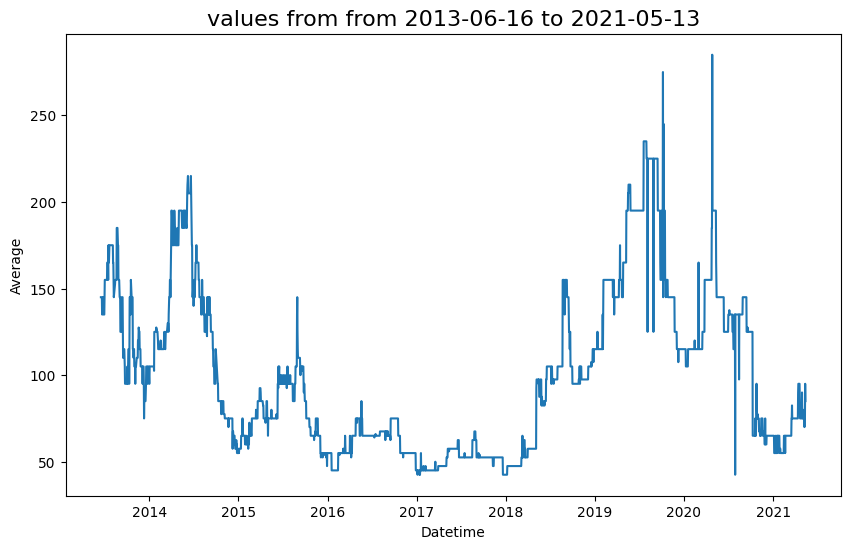

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Average'])
plt.title(f"values from from {date_range}", fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Average')
plt.show()

In [13]:
data = df.filter(['Average'])
dataset = data.values
data_train_len = int(np.ceil(len(dataset)* 0.8))

print(data_train_len)

2201


In [14]:
data_train = dataset[:data_train_len]
#data_train = data_train.flatten()
data_test = dataset[data_train_len:]
#data_test = data_test.flatten()


print(data_train.shape)
print(data_test.shape)


(2201, 1)
(550, 1)


In [15]:
skala_data = MinMaxScaler(feature_range=(0,1))
data_train_normalisasi = skala_data.fit_transform(data_train)
data_train_normalisasi = data_train_normalisasi.flatten()

data_test_normalisasi = skala_data.fit_transform(data_test)
data_test_normalisasi = data_test_normalisasi.flatten()

dataset_normalisasi = skala_data.fit_transform(dataset)



In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer): #code ini mengubah series menjadi numpy yang dapat diterima oleh model
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
train_set = windowed_dataset(data_train_normalisasi, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(data_test_normalisasi, window_size=60, batch_size=100, shuffle_buffer=1000)
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [18]:
minMae = (dataset_normalisasi.max() - dataset_normalisasi.min()) * 10/100
minMae

0.1

In [19]:
# Set the training parameters
class myEarlyStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<minMae and logs.get('val_mae')<minMae):
      self.model.stop_training = True

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [20]:
history = model.fit(train_set, validation_data = (validation_set), epochs=100, callbacks=[callback,myEarlyStop()])

Epoch 1/100
22/22 [==============================] - 28s 877ms/step - loss: 3.8819 - mae: 4.3667 - val_loss: 2.0999 - val_mae: 2.5999 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 16s 712ms/step - loss: 2.2430 - mae: 2.7430 - val_loss: 1.9098 - val_mae: 2.4098 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 16s 709ms/step - loss: 2.1360 - mae: 2.6360 - val_loss: 1.7818 - val_mae: 2.2818 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 16s 705ms/step - loss: 2.1245 - mae: 2.6245 - val_loss: 1.7698 - val_mae: 2.2698 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 16s 736ms/step - loss: 2.1289 - mae: 2.6289 - val_loss: 1.7844 - val_mae: 2.2844 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 15s 680ms/step - loss: 2.1254 - mae: 2.6254 - val_loss: 1.7229 - val_mae: 2.2229 - lr: 0.0010
Epoch 7/100
22/22 [==============================] - 15s 652ms/step - loss: 2.1224 - mae: 2.6224 - val_loss: 1.7169 - 

In [21]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

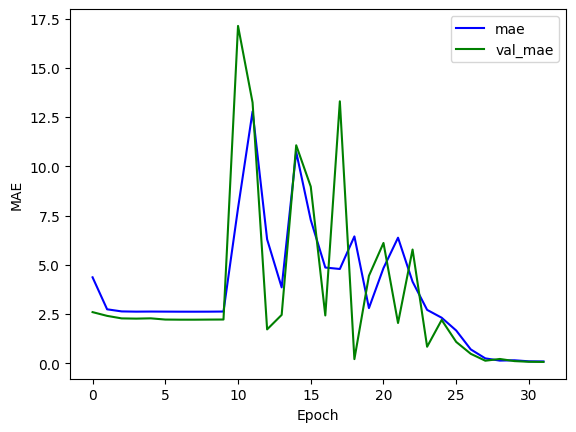

In [22]:

plt.plot(mae, 'b', label='mae')
plt.plot(val_mae, 'g', label='val_mae')

plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

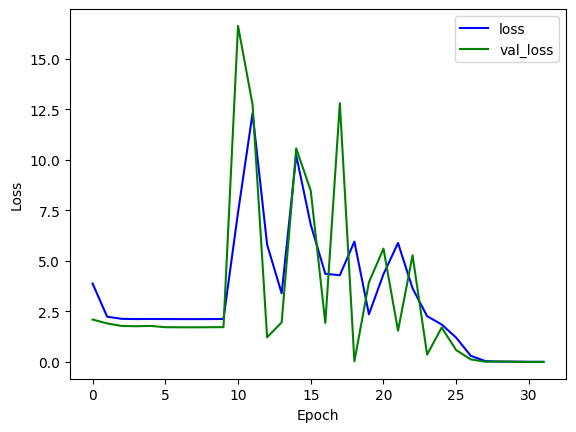

In [23]:
plt.plot(loss, 'b', label='loss')
plt.plot(val_loss, 'g', label='val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()